# Lab 2-1: Hypothesis Testing

The Skykomish River in Washington state appears to have had a change in streamflow around the year 1975. 
* Test for statistical significance of the observed change in the mean annual flood. 
* Use a two-sample test, with alpha=0.05 (i.e. 95% confidence) and the z-distribution to define the rejection region.

Why is it appropriate to use the z-distribution here? (consider the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem))

---

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Filepath to our excel file.
skykomish_data_file = '../data/Skykomish_peak_flow_12134500_WY1929_2023.xlsx'

# Use pandas.read_excel() function to open this file.
skykomish_data = pd.read_excel(skykomish_data_file)

# Now we can see the dataset we loaded:
skykomish_data.head(3)

/opt/conda/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:81: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,date of peak,water year,peak value (cfs),gage_ht (feet)
0,1928-10-09,1929,18800,10.55
1,1930-02-05,1930,15800,10.44
2,1931-01-28,1931,35100,14.08


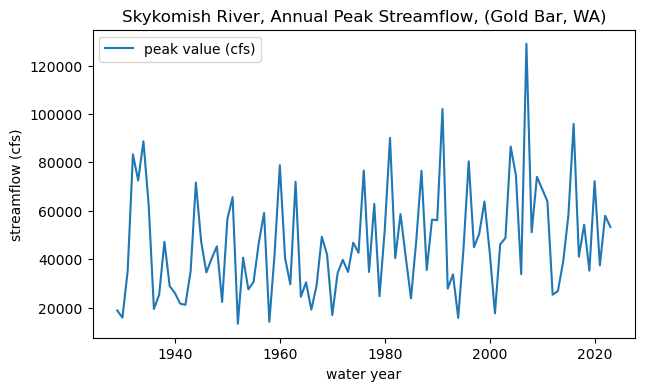

In [4]:
# Plot peak streamflows per water year
fig, ax = plt.subplots(figsize=(7,4))

skykomish_data.plot(x='water year', y='peak value (cfs)', ax=ax)
ax.set_ylabel('streamflow (cfs)');
ax.set_title('Skykomish River, Annual Peak Streamflow, (Gold Bar, WA)');

---

## Getting started with our hypothesis

We are postulating that there was a change in peak flows around 1977. In other words, how likely is it that the mean of peak flows before 1975 comes from the same distribution as the mean of peak flows after 1977?

To start, let's split the data in two:

In [5]:
# Divide the data into the early period (before 1977) and late period (after and including 1977). 

skykomish_before = skykomish_data[ skykomish_data['water year'] < 1977 ]
skykomish_after = skykomish_data[ skykomish_data['water year'] >= 1977 ]

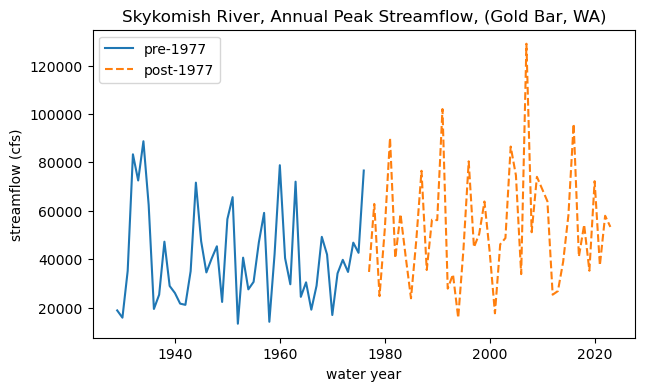

In [6]:
# Plot our two time periods
fig, ax = plt.subplots(figsize=(7,4))

skykomish_before.plot(x='water year', y='peak value (cfs)', ax=ax, linestyle='-', label='pre-1977')
skykomish_after.plot(x='water year', y='peak value (cfs)', ax=ax, linestyle='--', label='post-1977')

ax.set_ylabel('streamflow (cfs)');
ax.set_title('Skykomish River, Annual Peak Streamflow, (Gold Bar, WA)');

**What does the distribution of streamflows in each period look like?**

Plot a histogram for each period:

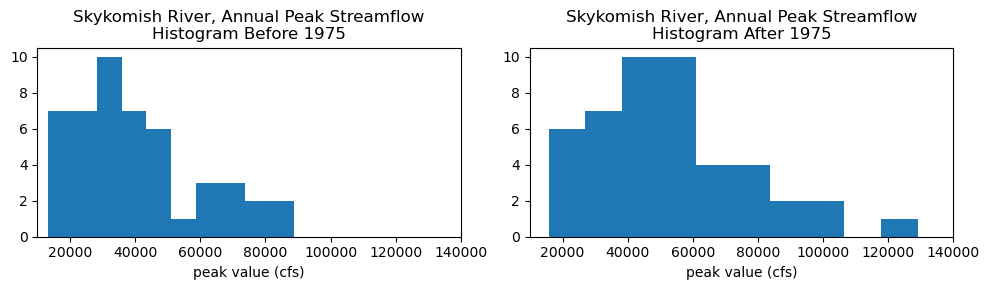

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

ax1.hist(skykomish_before['peak value (cfs)'], bins=10)
ax1.set_xlim((1e4,1.4e5))
ax1.set_xlabel('peak value (cfs)')
ax1.set_title('Skykomish River, Annual Peak Streamflow\nHistogram Before 1975')

ax2.hist(skykomish_after['peak value (cfs)'], bins=10)
ax2.set_xlim((1e4,1.4e5))
ax2.set_xlabel('peak value (cfs)')
ax2.set_title('Skykomish River, Annual Peak Streamflow\nHistogram After 1975');

plt.tight_layout()

---

## Cumulative distribution functions

Visually compare the distributions of the data, before and after 1977, with theoretical distributions, and random numbers generated from theoretical distributions.

In [8]:
### Method 1
# This function requires that the input is a pandas dataframe, with column names, and an integer index
# It returns a copy of the dataframe with an extra column added that has the Cunnane plotting positions
def cunnane_quantile(df, column_name):
    '''This function will compute the Cunnane plotting position for the values in a column of a dataframe.
    It requres a pandas dataframe, and the column name of interest (a text string) as inputs.
    The output is a new dataframe, ranked (sorted) with an extra column with the plotting position.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # Rank all our values
    ranked_df = df.sort_values(by=[column_name]).reset_index()
    
    # Calculate the Cunnane plotting position
    ranked_df['cunnane_plotting_position'] = ((ranked_df.index + 1) - (2/5)) / (ranked_df[column_name].count() + (1/5))
        
    return ranked_df

### Method 2
# This function should be able to accept any one-dimensional numpy array or list, of numbers
# It returns two numpy arrays, one of the sorted numbers, the other of the plotting position
def cunnane_quantile_array(numbers):
    '''This function also computes the Cunnane plotting position given an array or list of numbers (rather than a pandas dataframe).
    It has two outputs, first the sorted numbers, second the Cunnane plotting position for each of those numbers.
    [Steven Pestana, spestana@uw.edu, Oct. 2020]'''
    
    # 1) sort the data, using the numpy sort function (np.sort())
    sorted_numbers = np.sort(numbers)
    
    # length of the list of numbers
    n = len(sorted_numbers) 
    
    # make an empty array, of the same length. below we will add the plotting position values to this array
    cunnane_plotting_position = np.empty(n)
    
    # 2) compute the Cunnane plotting position for each number, using a for loop and the enumerate function
    for rank, number in enumerate(sorted_numbers):
        cunnane_plotting_position[rank] = ( (rank+1) - (2/5) ) / ( n + (1/5) )
    
    return sorted_numbers, cunnane_plotting_position

In [9]:
# Use the cunnane quantile function for before 1977
skykomish_before_b = cunnane_quantile(skykomish_before, 'peak value (cfs)')

# Create theoretical normal CDF based on our sample values before 1977
theoretical_cdf_b = stats.norm.cdf(skykomish_before_b['peak value (cfs)'].values,
                                 skykomish_before_b['peak value (cfs)'].mean(),
                                 skykomish_before_b['peak value (cfs)'].std(ddof=1))

# Generate random numbers from a theoretical normal CDF based on our samples before 1977
random_normal_b = np.random.normal(skykomish_before_b['peak value (cfs)'].mean(),
                                 skykomish_before_b['peak value (cfs)'].std(ddof=1),
                                 size=skykomish_before_b['peak value (cfs)'].count())

# Compute the Cunnane plotting position for the random numbers
random_sorted_b, random_quantiles_b  = cunnane_quantile_array(random_normal_b)

In [10]:
# Use the cunnane quantile function for after 1977
skykomish_after_a = cunnane_quantile(skykomish_after, 'peak value (cfs)')

# Create theoretical normal CDF based on our sample values before 1977
theoretical_cdf_a = stats.norm.cdf(skykomish_after_a['peak value (cfs)'].values,
                                 skykomish_after_a['peak value (cfs)'].mean(),
                                 skykomish_after_a['peak value (cfs)'].std(ddof=1))

# Generate random numbers from a theoretical normal CDF based on our samples before 1977
random_normal_a = np.random.normal(skykomish_after_a['peak value (cfs)'].mean(),
                                 skykomish_after_a['peak value (cfs)'].std(ddof=1),
                                 size=skykomish_after_a['peak value (cfs)'].count())

# Compute the Cunnane plotting position for the random numbers
random_sorted_a, random_quantiles_a  = cunnane_quantile_array(random_normal_a)

Text(0.5, 1.0, 'Skykomish River, Annual Peak Streamflow CDF\nAfter 1977')

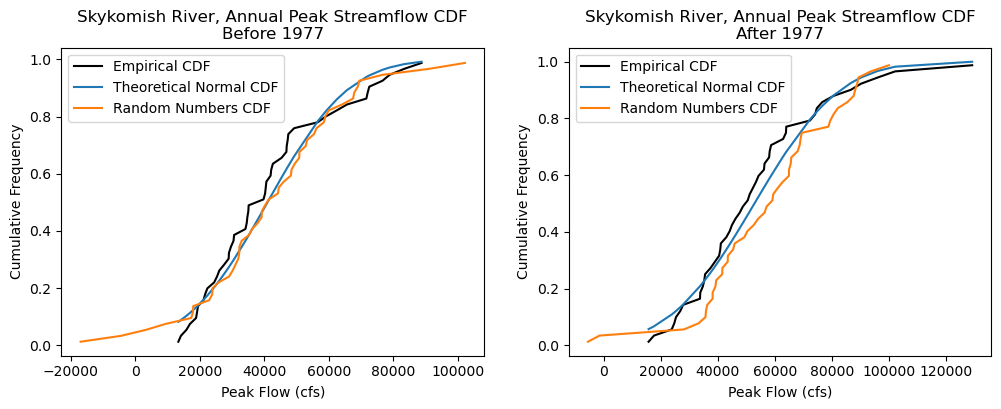

In [11]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

# Before 1975
# Empirical CDF
ax1.plot(skykomish_before_b['peak value (cfs)'], skykomish_before_b['cunnane_plotting_position'], color='k', label='Empirical CDF')
# Theorectical Normal CDF
ax1.plot(skykomish_before_b['peak value (cfs)'], theoretical_cdf_b, label='Theoretical Normal CDF')
# Random numbers CDF from a theoretical normal distribution
ax1.plot(random_sorted_b,random_quantiles_b,'-', label='Random Numbers CDF')
# Add legend and labels
ax1.legend()
ax1.set_ylabel('Cumulative Frequency')
ax1.set_xlabel('Peak Flow (cfs)')
ax1.set_title('Skykomish River, Annual Peak Streamflow CDF\nBefore 1977')

# After 1975
# Empirical CDF
ax2.plot(skykomish_after_a['peak value (cfs)'], skykomish_after_a['cunnane_plotting_position'], color='k', label='Empirical CDF')
# Theorectical Normal CDF
ax2.plot(skykomish_after_a['peak value (cfs)'], theoretical_cdf_a, label='Theoretical Normal CDF')
# Random numbers CDF from a theoretical normal distribution
ax2.plot(random_sorted_a, random_quantiles_a,'-', label='Random Numbers CDF')
# Add legend and labels
ax2.legend()
ax2.set_ylabel('Cumulative Frequency')
ax2.set_xlabel('Peak Flow (cfs)')
ax2.set_title('Skykomish River, Annual Peak Streamflow CDF\nAfter 1977')

Does the streamflow data look normally distributed? Maybe try changing the above code to compare the empirical CDFs against theoretical lognormal distributions. (Remember to transform the mean and standard deviations into "log space")

---
## Two-Sample Z-Test

#### Returning to our question: We are postulating (making a hypothesis) that there was a change in the mean flood statistics after 1977, and we want to test whether this is true.  Where do we start?

First we can formally state our null hypothesis, and our alternative hypothesis. We are also told to use a two sample test, and to set $\alpha$ at 5%.

Our **null hypothesis** is that the peak flows of the early period ($\bar{X}_1$) are drawn from the same distribution as the peak flows of the later period ($\bar{X}_2$) (therefore the distributions means of the two time periods are equal):

$H_0: \bar{X}_1 = \bar{X}_2$

Our **alternative hypothesis** is that the mean of the distribution for the later period is greater than that of the early period:

$H_1: \bar{X}_2 > \bar{X}_1$

We can also state these as:

$H_0: \bar{X}_1 - \bar{X}_2 = \mu_0$

$H_1: \bar{X}_1 - \bar{X}_2 < \mu_0$

Where $\mu_0$ is the hypothesized difference between the population means, and in this case $\mu_0 = \mu_1 - \mu_2 = 0$

Note that I have written a "[one-sided](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests)" test here because we are testing only for a change in one direction (an increase). We think that either the mean flood increased or it didn't change; we do not think the mean flood decreased:
* This might be chosen because we have some physical reason to think it increased (e.g. higher elevations in the watershed now get rainfall where it used to mostly get snow because of our warming climate).
* Or this might be chosen because we have some practical reason for the test to matter in this particular direction (e.g. we will change flood zoning downstream and/or how we operate a reservoir if the mean flood has increased, but won't make a change if it decreased).

### But which test should we use?  Is the z-distribution valid?

We are using the [z-test](https://en.wikipedia.org/wiki/Z-test), which uses the standard normal distribution. From our work above, we know that our data are likely not neccesarily normally distributed. However, the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) tells us that, "*If a sample of n values is extracted at random from a population with mean  μ and standard deviation σ, and n > 30, then the means of these samples are approximately normally distributed*"

We calculate our z-score as: $\displaystyle Z = \frac{ (\bar{X}_2 - \bar{X}_1) - \mu _{0} } { s_{1,2} }$

Where $s_{1,2}$ is the "pooled standard deviation", $s_1$, $s_2$ and $n_1$, $n_2$ are the two standard deviations and sample sizes respectively.

$s_{1,2} = \displaystyle\sqrt{ \displaystyle\frac{s^2_1}{n_1} + \displaystyle\frac{s^2_2}{n_2} }$

#### Remember, the means are normally distributed even if the data themselves are not normally distributed.

So what does the "**Null Distribution** look like?

And what do the "rejection regions" look like?

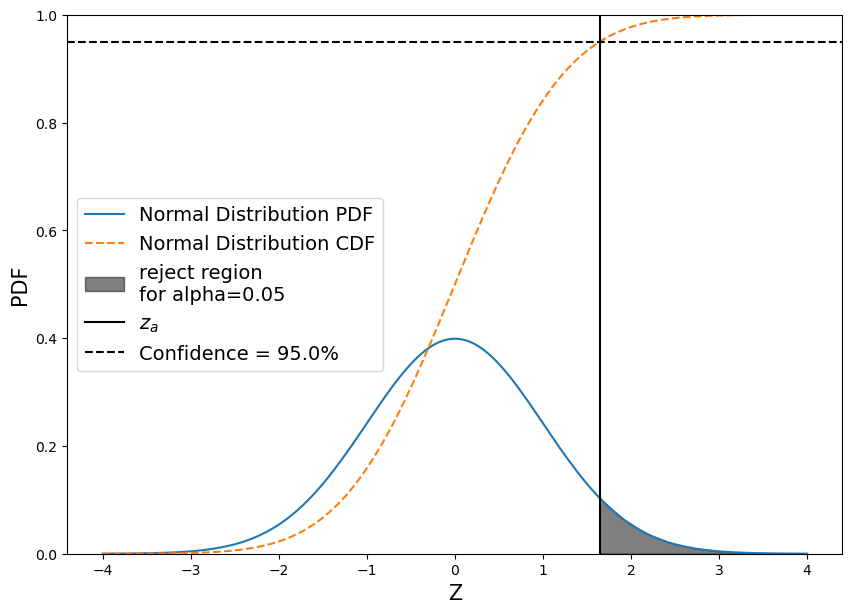

In [12]:
fig, ax = plt.subplots(figsize=(10,7))

# Create a null pdf
x = np.linspace(-4, 4, num=160)
ax.plot(x, stats.norm.pdf(x, 0, 1), label='Normal Distribution PDF')

# Plot the null cdf
ax.plot(x, stats.norm.cdf(x, 0, 1), linestyle='--', label='Normal Distribution CDF')

# Plot the region that z_test would have to fall in in order for us to reject the null hypothesis
conf = 0.95
z_alpha = stats.norm.ppf(conf)
shade = np.linspace(z_alpha, 4, 10)
ax.fill_between(shade, stats.norm.pdf(shade, 0, 1) ,  color='k', alpha=0.5, label='reject region\nfor alpha={}'.format(np.round(1-conf,2)))
# Plot a line at z_alpha
plt.axvline(z_alpha, color='black', label='$z_{a}$')
# Plot a line at our 95% confidence
plt.axhline(conf, color='black', linestyle='--', label='Confidence = {}%'.format(conf*100))


# Add labels
ax.set_ylim((0,1))
plt.xlabel('Z', fontsize=15)
plt.ylabel('PDF', fontsize=15)
ax.legend(loc='center left', fontsize=14);

In [13]:
# Check that we have a large enough sample size (n>30)

n = len(skykomish_before['peak value (cfs)'])
print(n)

m = len(skykomish_after['peak value (cfs)'])
print(m)

48
46


Both are larger than 30, so we can go ahead and calculate the z-score for our test:

In [14]:
# We want our alpha to be 0.05
alpha = 0.05
# This gives us a confidence of 0.95
conf = 1 - alpha

Next, determine which value in the z-distribution corresponds to our 0.95 confidence in the CDF

In [15]:
z_alpha = stats.norm.ppf(conf)
print("z_alpha = {}".format(z_alpha)) 

z_alpha = 1.6448536269514722


Compute the pooled standard deviation, $s_{1,2} = \displaystyle\sqrt{ \displaystyle\frac{s^2_1}{n_1} + \displaystyle\frac{s^2_2}{n_2} }$

In [16]:
# Compute the pooled standard deviation
pooled_sd = np.sqrt( skykomish_before['peak value (cfs)'].std(ddof=1)**2 / n + skykomish_after['peak value (cfs)'].std(ddof=1)**2 / m )

Finally, compute our z-score as  $\displaystyle Z = \frac{ (\bar{X}_2 - \bar{X}_1) - \mu _{0} } { s_{1,2} }$

In [17]:
# hypothesizing no change
mu_0 = 0

# compute z-score
zscore = (skykomish_after['peak value (cfs)'].mean() - skykomish_before['peak value (cfs)'].mean() - mu_0)/pooled_sd

print("z-score = {}".format( np.round(zscore,2) )) 

z-score = 2.63


We can also compute a p-value from this z-score by looking it up on the standard normal distribution CDF

In [18]:
pvalue = 1 - stats.norm.cdf(zscore)
print("p = {}".format( np.round(pvalue,3) ))

p = 0.004


Plot the z-distribution, our z-score test result, and the $z_\alpha$ that corresponds with our 95% confidence interval.

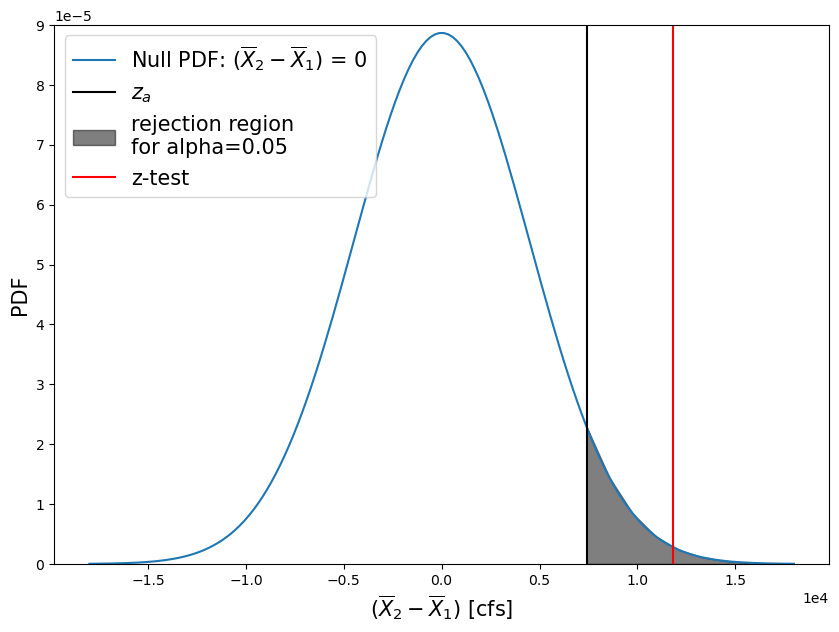

In [19]:
# Create z values between -4 and 4 to look at the middle portion of the z-distribution around 0
# Scale our values by the pooled standard deviation (otherwise we'd be in generic z-distribution space)
z = np.linspace(-4, 4, num=160) * pooled_sd

# Create the plot
plt.figure(figsize=(10,7))
# Plot the z-distribution here
plt.plot(z, stats.norm.pdf(z, 0, pooled_sd), label='Null PDF: ($\overline{X}_2 - \overline{X}_1$) = 0')

# Plot a line at our z-alpha value and shade the rejection region
plt.axvline(z_alpha*pooled_sd, color='black', linestyle='-', label='$z_{a}$')
shade = np.linspace(z_alpha*pooled_sd, np.max(z), 10)
plt.fill_between(shade, stats.norm.pdf(shade, 0, pooled_sd) ,  color='k', alpha=0.5, label='rejection region\nfor alpha={}'.format(np.round(1-conf,2)))


plt.axvline(zscore*pooled_sd, color='red', linestyle='-', label='z-test')
plt.xlabel('($\overline{X}_2 - \overline{X}_1$) [cfs]', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 9e-5)
plt.legend(loc='best', fontsize=15);

#### Questions:

What do these test results mean? 

What does it mean that our z-test value (red line) fell within our "rejection region" of the null hypothesis PDF?

What does our p-value tell us?

---

## Test a different hypothesis

How would the estimate of p change if our **null hypothesis** is now that the difference in the means is equal to 20% of the mean of the before-1977 period, and the alternative hypothesis is that a change more than 20% of the before-1977 period mean has occurred?

Therefore

$H_0: \bar{X}_1 - \bar{X}_2 = 0.2 \cdot \bar{X}_1$

$H_1: \bar{X}_1 - \bar{X}_2 < 0.2 \cdot \bar{X}_1$

Compute our z-score and p-value:

In [20]:
# hypothesizing a 20% change
mu_0 = 0.2 * skykomish_before['peak value (cfs)'].mean()

# compute z-score
zscore = (skykomish_after['peak value (cfs)'].mean() - skykomish_before['peak value (cfs)'].mean() - mu_0)/pooled_sd
print("z-score = {}".format( np.round(zscore,2) )) 

pvalue = 1 - stats.norm.cdf(zscore)
print("p = {}".format( np.round(pvalue,3) ))

z-score = 0.81
p = 0.209


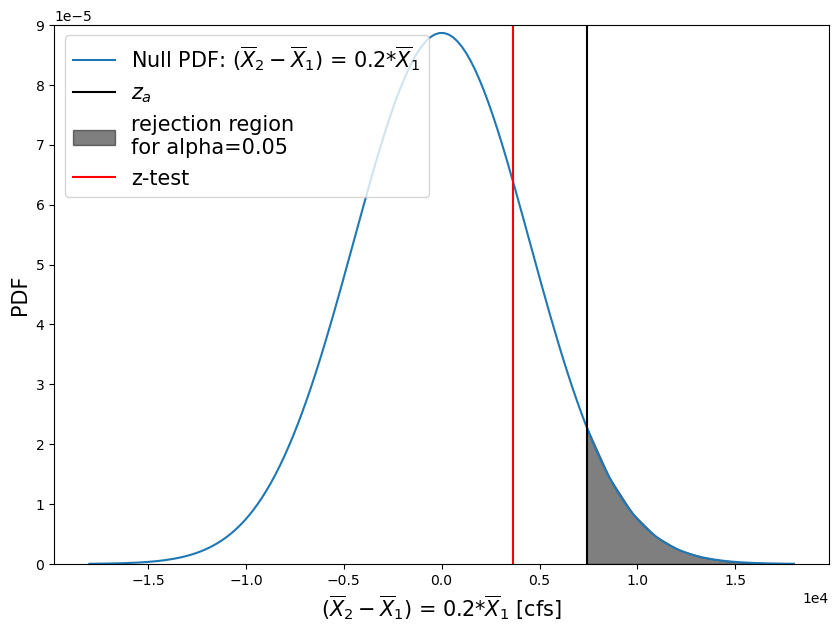

In [21]:
# Create z values between -4 and 4 to look at the middle portion of the z-distribution around 0
z = np.linspace(-4, 4, num=160)
# Scale our values by the pooled standard deviation (otherwise we'd be in generic z-distribution space)
z = [i * pooled_sd for i in z]

# Create the plot
plt.figure(figsize=(10,7))
# Plot the z-distribution here
plt.plot(z, stats.norm.pdf(z, 0, pooled_sd), label='Null PDF: ($\overline{X}_2 - \overline{X}_1$) = 0.2*$\overline{X}_1$')

# Plot a line at our z-alpha value and shade the rejection region
plt.axvline(z_alpha*pooled_sd, color='black', linestyle='-', label='$z_{a}$')
shade = np.linspace(z_alpha*pooled_sd, np.max(z), 10)
plt.fill_between(shade, stats.norm.pdf(shade, 0, pooled_sd) ,  color='k', alpha=0.5, label='rejection region\nfor alpha={}'.format(np.round(1-conf,2)))

plt.axvline(zscore*pooled_sd, color='red', linestyle='-', label='z-test')
plt.xlabel('($\overline{X}_2 - \overline{X}_1$) = 0.2*$\overline{X}_1$ [cfs]', fontsize=15)
plt.ylabel('PDF', fontsize=15)
plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.ylim(0, 9e-5)
plt.legend(loc='upper left', fontsize=15);

#### So what happened with this second test?

We created a more stringent test.

For example, say we will only recommend constructing taller levees along the river if the mean flood (defined by the annual peak flow) increased by more than 20%. While we can report that we are 95% sure that there is a change greater than 0 (our first test); we are **not** 95% sure that the change is greater than 20% of the early period mean.